In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import bz2
import re
import gc
import tensorflow as tf
import collections
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Function to assign labels and comments
def assign_labels_and_comments(file):
    labels = []
    comments = []
    for line in bz2.BZ2File(file):
        x = line.decode("utf-8")
        labels.append(int(x[9]) - 1)
        comments.append(x[10:].strip())
    return np.array(labels), comments

In [3]:
import pandas as pd
def get_data_from_file(filepath):
    labels = []
    texts = []
    with open(file=filepath, mode='r', encoding='utf-8') as file:
        for line in file.readlines():
            #       012345678901
            # line: __label__2 Stuning even for the non-gamer...
            labels.append(int(line[9]))
            texts.append(line[11:].strip())
    
    df = pd.DataFrame({'label': labels, 'text': texts})
    return df

# Load train data file
train_filepath = 'train.3270.txt'
df_train = get_data_from_file(train_filepath)

# Load test data file
test_filepath = 'test.135.txt'
df_test = get_data_from_file(test_filepath)

In [6]:
# Load and preprocess data
# test_labels, test_comments = assign_labels_and_comments('/kaggle/input/amazonreviews/test.ft.txt.bz2')
# train_labels, train_comments = assign_labels_and_comments('/kaggle/input/amazonreviews/train.ft.txt.bz2')
test_labels = df_test['label'].to_numpy()
test_comments = df_test['text'].to_list()

train_labels = df_train['label'].to_numpy()
train_comments = df_train['text'].to_list()



# Print the first 5 lines of the data
print("First 5 training comments and labels:")
for i in range(5):
    print(f"Label: {train_labels[i]}, Comment: {train_comments[i]}")

First 5 training comments and labels:
Label: 2, Comment: Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
Label: 2, Comment: The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth 

In [7]:
# Regular expressions for text cleaning
not_alphanumeric = re.compile(r'[\W]')
not_ascii = re.compile(r'[^a-z0-1\s]')

In [8]:
# Function to preprocess comments
def processed_comments(texts):
    processed_comments = []
    for text in texts:
        lower = text.lower()
        no_punctuation = not_alphanumeric.sub(r' ', lower)
        no_non_ascii = not_ascii.sub(r'', no_punctuation)
        processed_comments.append(no_non_ascii)
    return processed_comments

In [9]:
# Apply preprocessing
train_comments = processed_comments(train_comments)
test_comments = processed_comments(test_comments)

# Print the first 5 lines of the preprocessed data
print("\nFirst 5 preprocessed training comments:")
for i in range(5):
    print(f"Comment: {train_comments[i]}")


First 5 preprocessed training comments:
Comment: stuning even for the non gamer  this sound track was beautiful  it paints the senery in your mind so well i would recomend it even to people who hate vid  game music  i have played the game chrono cross but out of all of the games i have ever played it has the best music  it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras  it would impress anyone who cares to listen    
Comment: the best soundtrack ever to anything   i m reading a lot of reviews saying that this is the best  game soundtrack  and i figured that i d write a review to disagree a bit  this in my opinino is yasunori mitsuda s ultimate masterpiece  the music is timeless and i m been listening to it for years now and its beauty simply refuses to fade the price tag on this is pretty staggering i must say  but if you are going to buy any cd for this much money  this is the only one that i feel would be worth every penny 
Comme

In [10]:
# Split data into training and validation sets
train_comments, val_comments, train_labels, val_labels = train_test_split(train_comments, train_labels, random_state=42, test_size=0.2)

In [11]:
# Build vocabulary
def build_vocab(texts, max_features):
    counter = collections.Counter() # Đếm tần suất xuất hiện của mỗi từ trong văn bản
    for text in texts:
        counter.update(text.split()) # Cập nhật bộ đếm với các từ trong văn bản
    vocab = {word: i+1 for i, (word, _) in enumerate(counter.most_common(max_features - 1))}
    vocab['<UNK>'] = max_features  # Assign the last index to the unknown token
    return vocab

# Tokenize text to sequences
# Biến đổi văn bản thành các chuỗi chỉ số dựa trên từ vựng
def text_to_sequence(texts, vocab):
    sequences = []
    # Mỗi từ trong văn bản được chuyển đổi thành chỉ số của nó từ từ điển vocab.
    # Nếu từ không có trong từ điển, chỉ số của <UNK> được sử dụng
    for text in texts:
        sequences.append([vocab.get(word, vocab['<UNK>']) for word in text.split()])
    return sequences

# Pad sequences
# Đệm các chuỗi để có chiều dài cố định maxlen
def pad_sequences(sequences, maxlen):
    padded_sequences = np.zeros((len(sequences), maxlen), dtype=int)
    for i, seq in enumerate(sequences):
        # Nếu chuỗi dài hơn maxlen, cắt bớt nó.
        if len(seq) > maxlen:
            padded_sequences[i] = seq[:maxlen]
        # Nếu chuỗi ngắn hơn, đệm các phần tử từ bên trái bằng số 0.
        elif len(seq) > 0:  # Ensure non-empty sequences
            padded_sequences[i, -len(seq):] = seq
    return padded_sequences

# Maximum features
# Đặt giới hạn tối đa là 14,000 từ cho từ vựng.
maximum_features = 14000

# Build vocabulary
vocab = build_vocab(train_comments, maximum_features)

# Tokenize text to sequences
train_comments_seq = text_to_sequence(train_comments, vocab)
val_comments_seq = text_to_sequence(val_comments, vocab)
test_comments_seq = text_to_sequence(test_comments, vocab)

# Remove empty sequences and corresponding labels, after remove it only exists not empty sequences
train_comments_seq, train_labels = zip(*[(seq, label) for seq, label in zip(train_comments_seq, train_labels) if len(seq) > 0])
val_comments_seq, val_labels = zip(*[(seq, label) for seq, label in zip(val_comments_seq, val_labels) if len(seq) > 0])
test_comments_seq, test_labels = zip(*[(seq, label) for seq, label in zip(test_comments_seq, test_labels) if len(seq) > 0])

# Convert from tuple to lists
train_comments_seq = list(train_comments_seq)
val_comments_seq = list(val_comments_seq)
test_comments_seq = list(test_comments_seq)
train_labels = list(train_labels)
val_labels = list(val_labels)
test_labels = list(test_labels)

# Find maximum sequence length
maximum_length = max(max(len(seq) for seq in train_comments_seq),
                     max(len(seq) for seq in val_comments_seq),
                     max(len(seq) for seq in test_comments_seq))

# Pad sequences
train_comments_pad = pad_sequences(train_comments_seq, maximum_length)
val_comments_pad = pad_sequences(val_comments_seq, maximum_length)
test_comments_pad = pad_sequences(test_comments_seq, maximum_length)


In [12]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_comments_pad, train_labels)).batch(128)
val_dataset = tf.data.Dataset.from_tensor_slices((val_comments_pad, val_labels)).batch(128)
test_dataset = tf.data.Dataset.from_tensor_slices((test_comments_pad, test_labels)).batch(128)

In [13]:
# Convert labels to numpy arrays
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

print(train_comments_pad.shape[0])
print(train_labels.shape[0])
print(val_comments_pad.shape[0])
print(val_labels.shape[0])
print(test_comments_pad.shape[0])
print(test_labels.shape[0])

2616
2616
654
654
135
135


In [14]:
# Define the model
class SentimentModel(tf.Module):
    def __init__(self, vocab_size, embedding_dim, units):
        # Lớp embedding để chuyển đổi các từ thành các vector nhúng
        self.embedding = tf.Variable(tf.random.normal([vocab_size, embedding_dim]), name='embedding')
        # Lớp dense đầu tiên với kích thước trọng số embedding_dim x units
        self.dense_1 = tf.Variable(tf.random.normal([embedding_dim, units]), name='dense_1')
        # Lớp dense 2 với kích thước trọng số units x 1
        self.dense_2 = tf.Variable(tf.random.normal([units, 1]), name='dense_2')

    def __call__(self, x):
        x = tf.nn.embedding_lookup(self.embedding, x) # # Tìm các vector nhúng tương ứng với các chỉ số từ.
        x = tf.reduce_mean(x, axis=1)  # Average pooling để lấy trung bình của các vector nhúng
        x = tf.nn.relu(tf.matmul(x, self.dense_1)) # kích hoạt ReLU cho lớp dense thứ nhất
        x = tf.sigmoid(tf.matmul(x, self.dense_2)) # kích hoạt Sigmoid cho lớp đầu ra, dùng cho bài toán phân loại nhị phân
        return x
    

In [15]:
# model = CNNModel()

# Hyperparameters
vocab_size = maximum_features + 1  # +1 for padding token
embedding_dim = 128  # Kích thước của vector nhúng.
units = 64  # Số lượng đơn vị trong lớp dense ẩn
learning_rate = 0.001  # Tốc độ học cho bộ tối ưu hóa

# Initialize model
model = SentimentModel(vocab_size, embedding_dim, units)


In [16]:
# Loss and optimizer
loss_object = tf.losses.BinaryCrossentropy(from_logits=False)
optimizer = tf.optimizers.Adam(learning_rate)


In [17]:
# Metrics để đo lường trung bình hàm mất mát và độ chính xác nhị phân cho tập huấn luyện và tập xác thực.
train_loss = tf.metrics.Mean(name='train_loss')
train_accuracy = tf.metrics.BinaryAccuracy(name='train_accuracy')
val_loss = tf.metrics.Mean(name='val_loss')
val_accuracy = tf.metrics.BinaryAccuracy(name='val_accuracy')

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [18]:
# Training step
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:  # theo dõi các gradient cho các biến trong mô hình
        predictions = model(inputs)  # tính toán dự đoán từ mô hình
        loss = loss_object(labels, predictions)  # tính toán hàm mất mát
    gradients = tape.gradient(loss, model.trainable_variables)  # tính toán các gradient
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))  # cập nhật các biến mô hình dựa trên gradient

    # Cập nhật các chỉ số đo lường
    train_loss(loss)
    train_accuracy(labels, predictions)

In [19]:
# Validation step
@tf.function
def val_step(inputs, labels):
    predictions = model(inputs)
    v_loss = loss_object(labels, predictions)

    val_loss(v_loss)
    val_accuracy(labels, predictions)

In [20]:
# Training loop
epochs = 3
for epoch in range(epochs):
    for inputs, labels in train_dataset:
        train_step(inputs, labels)

    for val_inputs, val_labels in val_dataset:
        val_step(val_inputs, val_labels)

    # Save the metrics for this epoch
    train_losses.append(train_loss.result().numpy())
    val_losses.append(val_loss.result().numpy())
    train_accuracies.append(train_accuracy.result().numpy())
    val_accuracies.append(val_accuracy.result().numpy())
    
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Val Loss: {}, Val Accuracy: {}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          val_loss.result(),
                          val_accuracy.result() * 100))

    # Reset the metrics for the next epoch
    train_loss.reset_state()
    train_accuracy.reset_state()
    val_loss.reset_state()
    val_accuracy.reset_state()

Epoch 1, Loss: -4.467166423797607, Accuracy: 49.27370071411133, Val Loss: -6.781961917877197, Val Accuracy: 51.529048919677734
Epoch 2, Loss: -6.694466590881348, Accuracy: 54.35779571533203, Val Loss: -7.0872955322265625, Val Accuracy: 52.14067077636719
Epoch 3, Loss: -6.837071895599365, Accuracy: 54.54893112182617, Val Loss: -7.194677829742432, Val Accuracy: 52.2935791015625


In [21]:
# Batch prediction to manage memory usage
batch_size = 128  # số lượng mẫu được xử lý cùng một lúc
test_dataset = tf.data.Dataset.from_tensor_slices(test_comments_pad).batch(batch_size)
cnn_preds = []

for batch in test_dataset:
    preds = model(batch)
    cnn_preds.append(preds)

cnn_preds = tf.concat(cnn_preds, axis=0)
cnn_preds = (cnn_preds.numpy() > 0.5).astype(int)

In [22]:
# Calculate evaluation metrics
accuracy_cnn = accuracy_score(test_labels, cnn_preds)
f1_cnn = f1_score(test_labels, cnn_preds)
rocauc_cnn = roc_auc_score(test_labels, cnn_preds)
precision_cnn = precision_score(test_labels, cnn_preds)
recall_cnn = recall_score(test_labels, cnn_preds)

In [23]:
# Print evaluation results
# print('Accuracy score of the CNN Model: {:0.3f}'.format(accuracy_cnn))
# print('F1 score of the CNN Model: {:0.3f}'.format(f1_cnn))
# print('ROC AUC score of the CNN Model: {:0.3f}'.format(rocauc_cnn))

print(f'Accuracy score of the CNN Model: {accuracy_cnn * 100:.2f}%')
print(f'F1 score of the CNN Model: {f1_cnn * 100:.2f}%')
print(f'ROC AUC score of the CNN Model: {rocauc_cnn * 100:.2f}%')
print(f'Precision score of the CNN Model: {precision_cnn * 100:.2f}%')
print(f'Recall score of the CNN Model: {recall_cnn * 100:.2f}%')

Accuracy score of the CNN Model: 44.44%
F1 score of the CNN Model: 61.54%
ROC AUC score of the CNN Model: 50.00%
Precision score of the CNN Model: 44.44%
Recall score of the CNN Model: 100.00%


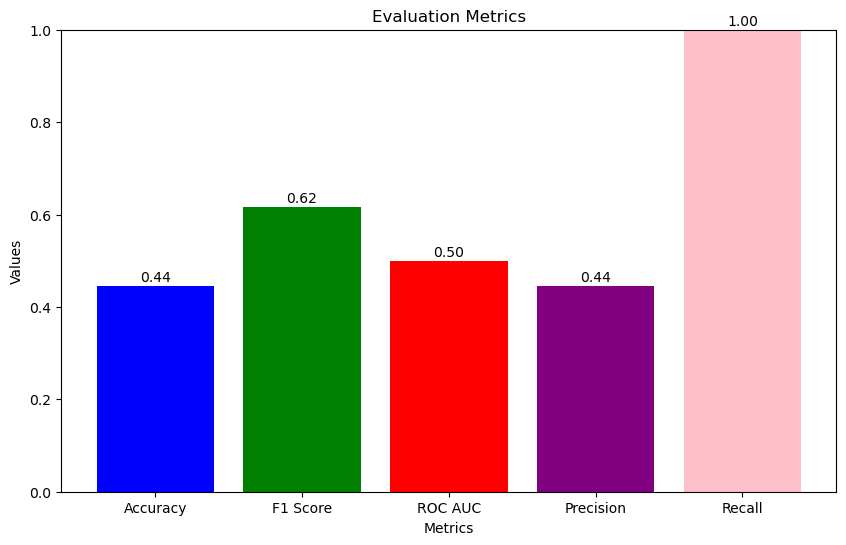

In [24]:
# Vẽ biểu đồ cho các chỉ số đánh giá
metrics = ['Accuracy', 'F1 Score', 'ROC AUC', 'Precision', 'Recall']
values = [accuracy_cnn, f1_cnn, rocauc_cnn, precision_cnn, recall_cnn]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple', 'pink'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Evaluation Metrics')
for i, value in enumerate(values):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center')
plt.ylim(0, 1)
plt.show()

In [25]:
# Biểu đồ huấn luyện và độ chính xác theo từng epoch trong quá trình huấn luyện
epochs_range = range(epochs)

# plt.figure(figsize=(14, 7))

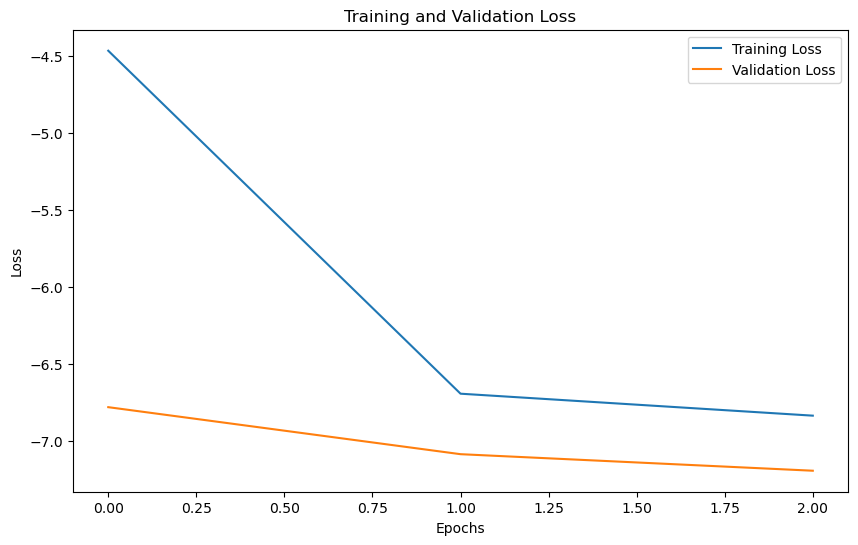

In [26]:
# Plot Loss
# plt.subplot(1, 2, 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

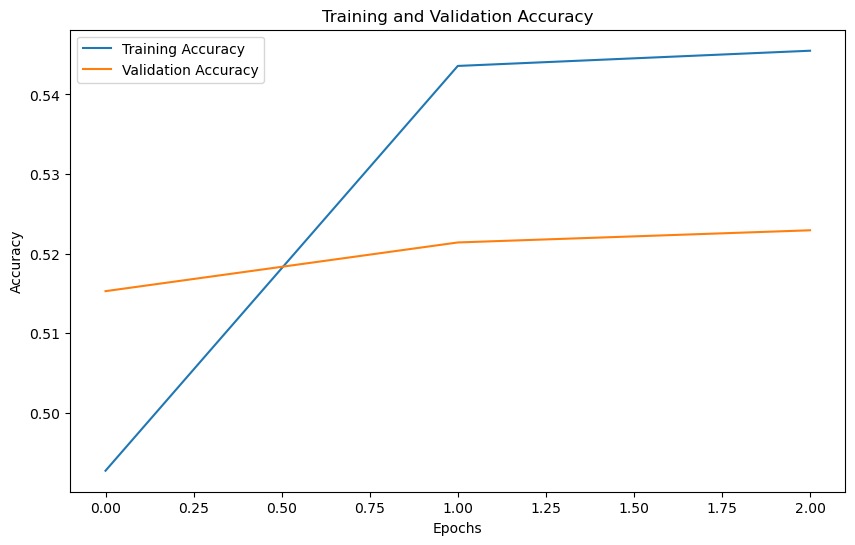

In [27]:
# Plot Accuracy
# plt.subplot(1, 2, 2)
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

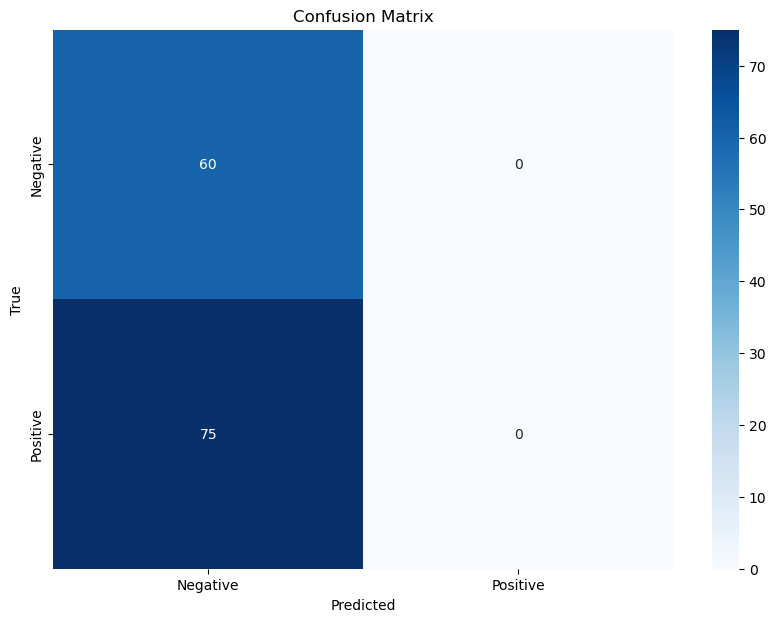

In [28]:
# Plot Confusion Matrix: thể hiện sự phân bố của các dự đoán đúng và sai của mô hình
cm = confusion_matrix(test_labels, cnn_preds)  # Tính ma trận nhầm lẫn (Confusion Matrix)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

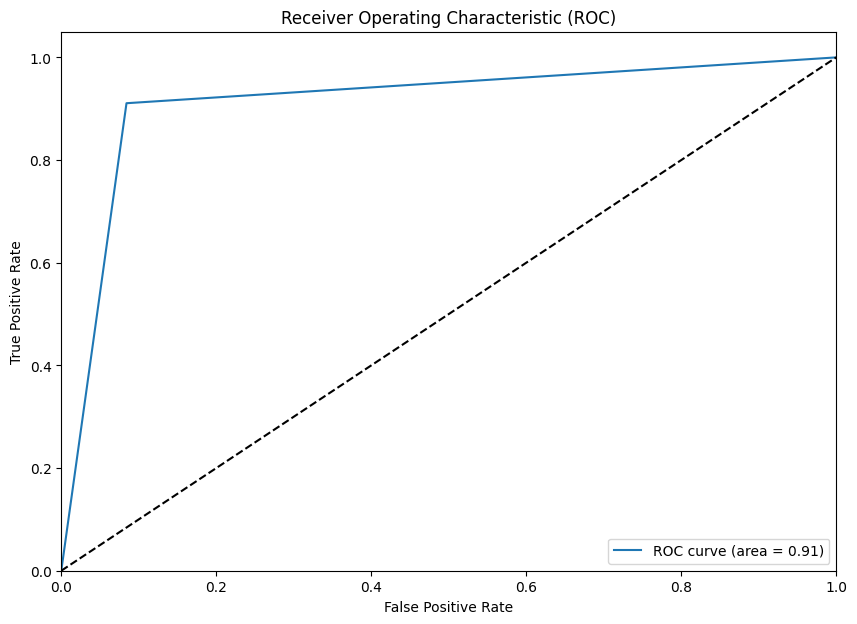

In [27]:
# Plot ROC Curve: giúp đánh giá khả năng phân biệt giữa các lớp của mô hình.
# Tính ROC curve
fpr, tpr, _ = roc_curve(test_labels, cnn_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [28]:


# Function to predict sentiment of a given text
def predict_sentiment(text):
    # Preprocess text
    lower = text.lower()
    not_alphanumeric = re.compile(r'[\W]')
    not_ascii = re.compile(r'[^a-z0-1\s]')
    no_punctuation = not_alphanumeric.sub(r' ', lower)
    no_non_ascii = not_ascii.sub(r'', no_punctuation)
    
    # Tokenize text
    tokens = no_non_ascii.split()
    token_ids = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    
    # Pad sequence
    padded_sequence = pad_sequences([token_ids], maximum_length)
    
    # Convert sequence to tensor
    input_tensor = tf.convert_to_tensor(padded_sequence, dtype=tf.int32)
    
    # Make prediction
    prediction = model(input_tensor)
    pred = prediction.numpy()[0][0]
    
    # Return prediction result
    return 'Positive' if pred >= 0.5 else 'Negative'

# Example usage
# text = 'My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I am in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing'
text = "I don't like this book"
predicted_sentiment = predict_sentiment(text)
print(f'The sentiment of the text is: {predicted_sentiment}')



new_reviews = [
    "This product is great!",
    "This product is terrible.",
    "This product is good but it's expensive.",
    "Absolutely love this!",
    "Not what I expected."
]

for review in new_reviews:
    sentiment = predict_sentiment(review)
    print(f'Review: "{review}" - Sentiment: {sentiment}')



The sentiment of the text is: Negative
Review: "This product is great!" - Sentiment: Positive
Review: "This product is terrible." - Sentiment: Negative
Review: "This product is good but it's expensive." - Sentiment: Positive
Review: "Absolutely love this!" - Sentiment: Positive
Review: "Not what I expected." - Sentiment: Negative


In [29]:
# Clean up memory
gc.collect()

16321